# Capítulo 1 – Introducción a la Detección de Anomalías

Antes de entrar en la parte técnica del proyecto, es importante contextualizar el propósito y el origen de los datos utilizados.

El objetivo general consiste en aplicar **técnicas de detección de anomalías no supervisadas** sobre datos extraídos de archivos **MDF (Measurement Data Format)**, sin contar con etiquetas fiables ni retroalimentación de expertos o responsables del sistema de origen. Por tanto, para empezar trataremos con la definición general de anomalía en series temporales.

**Una anomalía es una situación que se desvía significativamente del comportamiento esperado.**

Los archivos MDF utilizados provienen del **rodaje de un vehículo prototipo que aún no ha salido al mercado**. Hasta ahora, los expertos del dominio han trabajado con este tipo de datos de forma parcial, apoyándose en reglas conocidas de antemano: por ejemplo, si tras un impacto no se activa el airbag ni los intermitentes, se considera una anomalía evidente. Sin embargo, este enfoque se limita a **situaciones esperadas o visibles**, dejando fuera una gran variedad de comportamientos inesperados que podrían ser igual o más críticos, pero difíciles de anticipar.

Aquí es donde se enmarca este proyecto: como una **fase inicial exploratoria**, en la que se pretende evaluar el potencial real de aplicar algoritmos no supervisados a este tipo de señales. 

Aunque no se dispone de información detallada sobre la presencia de anomalías en los rodajes de los vehículos, resulta necesario dotar al trabajo de una base empírica que vaya más allá de simples conjeturas. Para ello, la primera etapa consistirá en recopilar distintos conjuntos de datos que ya cuenten con anomalías señaladas en sus series temporales. Sobre estas bases se llevará a cabo la validación y comparación de varios métodos de detección —desarrollados específicamente para este proyecto— con el objetivo de identificar el enfoque más fiable. Una vez seleccionado, dicho método se aplicará posteriormente a los datos contenidos en los archivos MDF.

Antes de profundizar en los conjuntos de datos y en las metodologías de validación y comparación, resulta pertinente realizar una breve introducción al campo de la detección de anomalías en series temporales, comenzando por los conceptos fundamentales que servirán de marco para el resto del trabajo.

## Contenido del capítulo

En este capítulo se presentarán los **fundamentos teóricos básicos** que permitirán entender qué se considera una anomalía desde un punto de vista estadístico y computacional. También se incluirán **representaciones gráficas sencillas** que ilustran cómo pueden detectarse estas desviaciones en el espacio de características.

Todo ello servirá como punto de partida para las siguientes etapas del trabajo, en las que se aplicarán y evaluarán distintas estrategias de detección sobre señales reales extraídas de archivos MDF.


## Anomalías en series temporales

Según **Chandola et al. (2009)**, una anomalía en una serie temporal es un **punto, subsecuencia o patrón que no se ajusta al comportamiento esperado del resto de la secuencia**. Las series temporales presentan una dificultad añadida frente a otras formas de datos, debido a que el tiempo impone una estructura secuencial: los valores consecutivos están correlacionados y condicionados por patrones como tendencia, estacionalidad o ruido.

### Tipos de anomalías en series temporales

Es común clasificar las anomalías temporales en tres grandes categorías:

1. **Anomalía puntual (Point anomaly)**  
   Un único punto que se desvía significativamente del comportamiento general.  
   *Ejemplo:* un pico de temperatura aislado.

2. **Anomalía contextual (Contextual anomaly)**  
   El valor parece normal en general, pero no lo es considerando su contexto.  
   *Ejemplo:* 25 °C en verano es normal; en invierno podría ser anómalo.

3. **Anomalía colectiva (Collective anomaly)**  
   Un grupo de valores que en conjunto forman un patrón anómalo, aunque individualmente no lo parezcan.  
   *Ejemplo:* un descenso sostenido en la presión de un sistema.

[[[[IMG ANAOMALIA PUNTUAL; CONEXTUAL; COLECTIVA]]]]

## Componentes de una señal temporal

Desde un punto de vista clásico, una señal temporal puede descomponerse en varios componentes fundamentales:

- **Tendencia (Trend):** refleja cambios a largo plazo en el valor medio de la señal.
- **Estacionalidad (Seasonality):** patrones que se repiten de forma regular en el tiempo, como los ciclos horarios, diarios o anuales.
- **Ruido (Noise):** fluctuaciones aleatorias sin estructura aparente.
- **Eventos transitorios:** desviaciones breves y localizadas que alteran momentáneamente el patrón general.

Esta descomposición permite analizar por separado las distintas fuentes de variación de una señal y es ampliamente utilizada en ámbitos como la predicción de demanda, la meteorología, los procesos industriales o el análisis financiero.


## Ejemplo: Descomponer una señal temporal en sus componentes básicos

La descomposición de series temporales es una técnica clásica que permite separar los distintos factores que influyen en una señal.  
En este ejemplo práctico vamos a mostrar cómo, a partir de una señal sintética, podemos identificar:

- **La tendencia**: evolución a largo plazo.  
- **La estacionalidad**: ciclos repetitivos.  
- **El residuo**: variabilidad aleatoria y posibles anomalías.  

Para ilustrarlo, generaremos primero una señal con todos estos elementos y una anomalía puntual controlada. Después aplicaremos la función `seasonal_decompose` para obtener la descomposición en sus componentes.


## Tarea 1: Preparación de la señal temporal

Antes de aplicar una técnica de descomposición, necesitamos contar con una señal temporal sobre la que trabajar.  
En esta primera tarea vamos a **importar las librerías necesarias** y **generar una serie sintética** que combine:

- Una **tendencia lineal** creciente.  
- Un componente de **estacionalidad sinusoidal** que simula ciclos diarios.  
- Un **ruido gaussiano** para introducir variabilidad.  

Para facilitar el análisis posterior, también introduciremos una **anomalía puntual controlada** en un instante concreto de la serie.


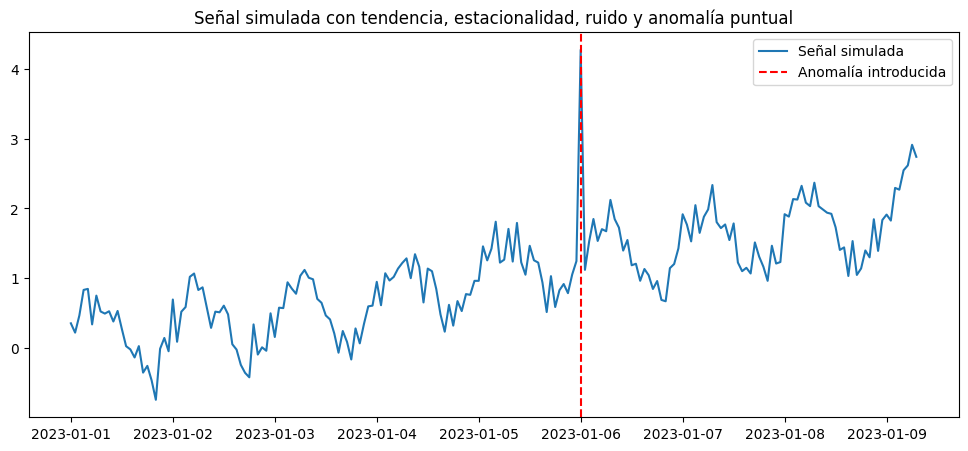

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulación de una señal con tendencia, estacionalidad y ruido
np.random.seed(0)
t = np.arange(200)
tendencia = 0.01 * t
estacionalidad = 0.5 * np.sin(2 * np.pi * t / 24)
ruido = np.random.normal(0, 0.2, size=len(t))
serie = tendencia + estacionalidad + ruido

# Introducir una anomalía clara en el punto 120
serie[120] += 3  # pico anómalo

# Convertir a serie temporal con índice horario
serie_df = pd.DataFrame({'valor': serie}, index=pd.date_range("2023-01-01", periods=len(t), freq="h"))

# Visualización inicial de la señal
plt.figure(figsize=(12, 5))
plt.plot(serie_df.index, serie_df['valor'], label="Señal simulada")
plt.axvline(serie_df.index[120], color="red", linestyle="--", label="Anomalía introducida")
plt.title("Señal simulada con tendencia, estacionalidad, ruido y anomalía puntual")
plt.legend()
plt.show()


## Tarea 2: Aplicación de la descomposición temporal

Una vez generada la señal, el siguiente paso consiste en **descomponerla en sus principales componentes**:  

- **Tendencia**  
- **Estacionalidad**  
- **Residuo** (o ruido, que también recoge las anomalías)

Para ello utilizaremos la función `seasonal_decompose` de la librería `statsmodels`, que implementa la descomposición clásica de series temporales en un modelo aditivo.  
Definiremos un periodo de 24 observaciones, correspondiente a un ciclo diario simulado en la serie sintética.

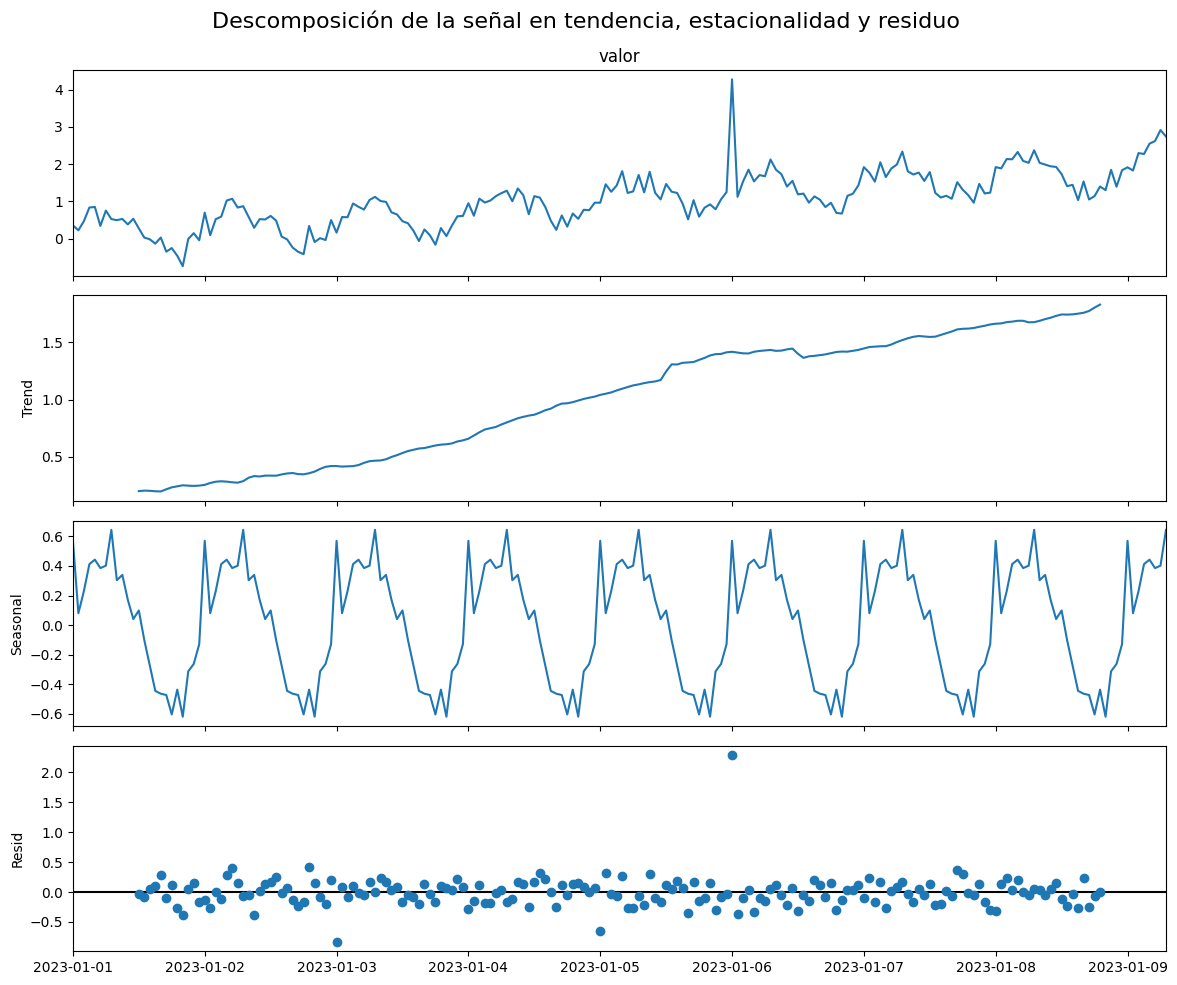

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicar descomposición estacional (modelo aditivo, con periodo diario simulado)
descomp = seasonal_decompose(serie_df['valor'], model='additive', period=24)

# Crear figura más grande y mostrar
fig = descomp.plot()
fig.set_size_inches(12, 10)
plt.suptitle("Descomposición de la señal en tendencia, estacionalidad y residuo", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## La descomposición para detectar anomalías

Como se puede intuir viendo la gráfica anterior, una de las aplicaciones más comunes de la descomposición de series temporales es la **detección de anomalías a través del análisis del residuo**.

El razonamiento es el siguiente:

1. Se descompone la señal en sus componentes: tendencia, estacionalidad y residuo.  
2. Si la señal se comporta como se espera (es decir, sigue su tendencia y estacionalidad habituales), entonces el **residuo debería comportarse como ruido aleatorio sin estructura ni valores extremos**.  
3. Por tanto, cualquier **valor atípico o pico en el residuo** puede interpretarse como una posible **anomalía**.

Este enfoque puede automatizarse combinando la descomposición con técnicas estadísticas (por ejemplo, detección de outliers mediante desviación estándar o IQR) o con modelos de aprendizaje automático aplicados directamente al residuo.

## Utilidad de la descomposición en nuestras señales

Conocer la descomposición de una serie en **tendencia**, **patrón repetitivo** y **resto** ayuda a entender cómo se comporta una señal y qué variaciones pueden aparecer. En **señales de sensores de vehículo**, su utilidad es variable:  

- En algunos casos existen **patrones muy breves** o ciclos ligados al control del sistema.  
- En muchos otros, **no hay estacionalidad clara** y el comportamiento depende más de las **condiciones dinámicas** del momento.

Por ello, **no la tomaremos como un paso obligatorio**, pero sí como una herramienta que puede emplearse de manera selectiva cuando detectemos patrones repetitivos razonables o cambios de nivel que merezca la pena separar.

El análisis de anomalías se abordará con técnicas adaptadas a la naturaleza de estas señales, combinando:

- **Modelos basados en rareza estadística**


## Principios generales de la detección de anomalías

La detección de anomalías constituye un campo amplio en el que coexisten numerosos enfoques y algoritmos. Sin embargo, en términos conceptuales, la mayoría de los métodos comparten una idea central: **identificar desviaciones respecto al comportamiento considerado normal** en los datos.

De manera general, el procedimiento implica dos pasos:

1. **Definición de lo normal:** cada modelo aprende, explícita o implícitamente, una representación del comportamiento esperado de la señal.  
2. **Medición de la desviación:** cada nueva observación se evalúa en relación con ese patrón de normalidad, asignándole un valor que refleja su grado de anormalidad.

Este valor se conoce comúnmente como **score de anomalía**, y puede calcularse de diversas formas:

- **Análisis del residuo en descomposiciones:** tras extraer tendencia y estacionalidad, cualquier comportamiento inesperado debería reflejarse en el residuo. Un residuo que muestre valores atípicos o estructura no aleatoria se interpreta como indicador de anomalía.  
- **Error de predicción en modelos predictivos:** en métodos que estiman el valor futuro de la serie, la discrepancia entre la predicción y el valor observado se utiliza como score de anomalía.  
- **Error de reconstrucción en modelos de codificación-decodificación:** en arquitecturas como los Autoencoders, los datos normales se reconstruyen con bajo error, mientras que los anómalos presentan un error de reconstrucción elevado.  

Una vez calculado el score, el proceso concluye aplicando un **criterio de decisión**, habitualmente un **umbral (threshold)**. Los valores que superan dicho umbral se consideran anomalías. En este marco:

- **Score bajo:** indica comportamiento normal.  
- **Score alto:** sugiere comportamiento anómalo.  

En definitiva, aunque los modelos difieren en la forma de aprender y representar la normalidad, así como en el cálculo del score, el esquema subyacente es común: **asignar una medida de rareza a cada observación y compararla con un criterio de decisión**.

---

## Referencias

- Chandola, V., Banerjee, A., & Kumar, V. (2009).  
  *Anomaly detection: A survey.* ACM Computing Surveys, 41(3), 1–58.  

- Oh, S., Yoon, S., & Yun, I. (2018).  
  *Residual error based anomaly detection using auto-encoders.* Sensors, 18(5), 1308.
